# Deep Learning using Biologically Relevant Features

## Using TabNet

TabNet is an attention based neural network, it uses sequential attention to select features at each step, improving interpretability and efficiency during learning. It is based on the paper by Sercan O. Arik, Tomas Pfister, [TabNet: Attentive Interpretable Tabular Learning](https://arxiv.org/abs/1908.07442).


Its main advantages are:
1. TabNet uses raw tabular data without any preprocessing.
2. Uses squential attention to select features enabling interpretavility and efficiency. And it uses a single deep learning architecture for the feature selection and reasoning.
3. Two types of interpretability: *local interpretability* to visualize the importance of features and how they are combined, and *global interpretabiity* that quantifies the contribution of each feature to the trained model

The features are biologically relevant features extracted from the BRACS dataset

## Loading the data and necessary packages

In [ ]:
from fastai.basics import *
from fastai.tabular.all import *
# !pip install fast-tabnet
from fast_tabnet.core import *

In [ ]:
df_train = pd.read_csv('data_train.csv')
df_test = pd.read_csv('data_test.csv')
df_val = pd.read_csv('data_val.csv')

feature_names = ['radius_me', 'texture_me', 'perimeter_me', 'area_me', 'smoothness_me', 'compactness_me', 'solidity_me','radius_stde', 'texture_stde', 'perimeter_stde', 'area_stde', 'smoothness_stde', 'compactness_stde', 'solidity_stde','radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'solidity_worst','density','numbofcells','densityinzone','zonearea']

df_train.head()

,radius_me,texture_me,perimeter_me,area_me,smoothness_me,compactness_me,solidity_me,radius_stde,texture_stde,perimeter_stde,...,smoothness_worst,compactness_worst,solidity_worst,density,numbofcells,densityinzone,zonearea,class,subclass,filename
0,986.630768,22.780218,91.271563,260.311647,8.557446,35.666589,0.740460,21.820834,0.185925,1.401329,...,36.218342,192.031449,0.989950,348.081443,953,1276.814529,0.272617,Benign,N,BRACS_1003675_N_1.png
1,482.412027,16.710158,75.975529,297.093333,6.847186,19.933157,0.863773,15.024493,0.238260,1.443049,...,20.741597,157.818460,0.990338,508.941825,450,1299.573307,0.391622,Benign,N,BRACS_1003713_N_1.png
2,1446.802047,19.760976,77.540422,294.314741,7.989395,21.514353,0.854669,28.478632,0.180613,1.069696,...,35.367612,199.587399,0.991903,233.738962,1004,1440.379032,0.162276,Benign,N,BRACS_1003714_N_1.png
3,719.492538,16.181143,83.022172,290.167449,6.569806,25.939459,0.809905,26.208741,0.201540,1.446327,...,22.758242,127.046457,0.993151,235.950459,639,901.788494,0.261647,Benign,N,BRACS_1003715_N_1.png
4,670.893272,11.958551,81.596014,288.158371,7.282739,23.875232,0.817291,33.259959,0.274124,2.056982,...,22.874512,71.708188,0.972332,244.424245,221,979.032209,0.249659,Benign,N,BRACS_1003716_N_1.png


And we can create the full dataframe: train-validation

In [ ]:
np.random.seed(42) #so results are consistent
full_df = pd.concat([df_train, df_val])
val_indices = list(range(len(df_train),len(df_train) + len(df_val)))
ind_splitter = IndexSplitter(val_indices)
splits = ind_splitter(full_df)
preprocessing = [Normalize]


## Create dataloaders

In [ ]:
to = TabularPandas(full_df, procs=preprocessing, cont_names=feature_names,
                   y_names='class', splits=splits)

dls = to.dataloaders(bs=2048)
to.all_cols.head()

,radius_me,texture_me,perimeter_me,area_me,smoothness_me,compactness_me,solidity_me,radius_stde,texture_stde,perimeter_stde,...,perimeter_worst,area_worst,smoothness_worst,compactness_worst,solidity_worst,density,numbofcells,densityinzone,zonearea,class
0,0.164153,2.392303,0.769532,-1.258873,2.214544,1.960116,-1.841048,0.146635,-0.033960,-0.170191,...,1.331204,-0.457180,2.318664,1.725845,0.373026,-0.775843,-0.110814,0.443285,-1.351720,1
1,-0.819379,0.603458,-1.060414,-0.249756,-0.711413,-1.053384,1.120451,-1.228068,0.403834,-0.129159,...,-1.211670,-0.626510,-0.334591,0.907431,0.418377,0.340297,-0.589737,0.511542,-0.252644,1
2,1.061766,1.502533,-0.873198,-0.325988,1.242707,-0.750530,0.901794,1.493313,-0.078398,-0.496363,...,-0.171623,0.179825,2.172819,1.906592,0.601082,-1.569216,-0.062255,0.933842,-2.370778,1
3,-0.356928,0.447557,-0.217387,-0.439770,-1.185962,0.097032,-0.173261,1.034181,0.096665,-0.125935,...,0.383754,-0.134646,0.011133,0.171329,0.746796,-1.553871,-0.409784,-0.681481,-1.453032,1
4,-0.451726,-0.796839,-0.388005,-0.494889,0.033742,-0.298339,0.004118,2.460437,0.703847,0.474664,...,-0.813771,-0.537813,0.031066,-1.152425,-1.684177,-1.495075,-0.807776,-0.449814,-1.563749,1


## Model structure definition & initial training



This is the structure of a TabNet model:

Many different values we can input, summary:

* n_d: Dimensions of the prediction layer (usually between 4 to 64)
* n_a: Dimensions of the attention layer (similar to n_d)
* n_steps: Number of sucessive steps in our network (usually 3 to 10)
* gamma: A scaling factor for updating attention (usually between 1.0 to 2.0)
* momentum: Momentum in all batch normalization
* n_independent: Number of independant GLU layers in each block (default is 2)
* n_shared: Number of shared GLU layers in each block (default is 2)
* epsilon: Should be kept very low

In [ ]:
emb_szs = get_emb_sz(to); emb_szs


[]

In [ ]:
model = TabNetModel(emb_szs, len(to.cont_names), dls.c, n_d=256, n_a=256, n_steps=2, mask_type='entmax');
learn = Learner(dls, model, CrossEntropyLossFlat(), opt_func=SGD, lr=3e-2, metrics=[accuracy])
learn.add_cb(ShowGraphCallback())

We can use the learning rate finding tool in FastAI to get an idea of an appropriate LR we can use:

SuggestedLRs(valley=0.007585775572806597)

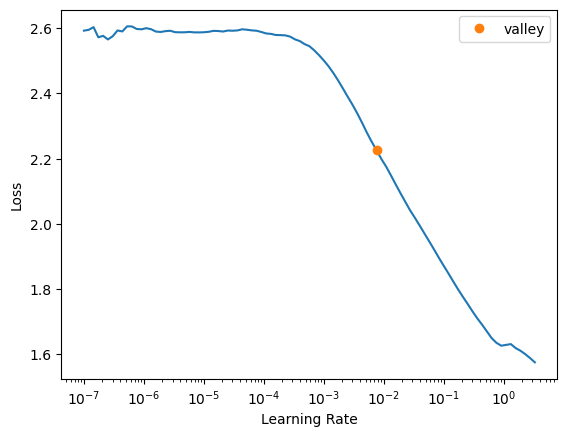

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,2.264468,3.021008,0.392027,00:05
1,2.265515,1.900255,0.378738,00:03
2,2.227958,1.681086,0.408638,00:04
3,2.219460,1.507617,0.408638,00:01
4,2.199020,1.428789,0.405316,00:01
5,2.168438,1.428602,0.415282,00:01
6,2.152807,1.437799,0.408638,00:02
7,2.139735,1.446290,0.392027,00:02
8,2.126400,1.452032,0.388704,00:01
9,2.090928,1.462673,0.395349,00:01


Better model found at epoch 0 with valid_loss value: 3.021007776260376.


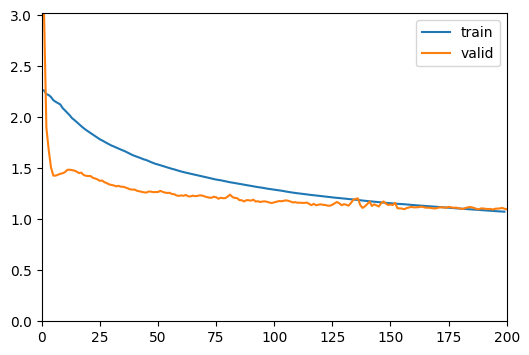

Better model found at epoch 1 with valid_loss value: 1.9002549648284912.
Better model found at epoch 2 with valid_loss value: 1.6810861825942993.
Better model found at epoch 3 with valid_loss value: 1.5076168775558472.
Better model found at epoch 4 with valid_loss value: 1.4287891387939453.
Better model found at epoch 5 with valid_loss value: 1.4286017417907715.
Better model found at epoch 18 with valid_loss value: 1.4271658658981323.
Better model found at epoch 19 with valid_loss value: 1.424599528312683.
Better model found at epoch 20 with valid_loss value: 1.4245649576187134.
Better model found at epoch 21 with valid_loss value: 1.407222867012024.
Better model found at epoch 22 with valid_loss value: 1.400160312652588.
Better model found at epoch 23 with valid_loss value: 1.3912642002105713.
Better model found at epoch 24 with valid_loss value: 1.3776953220367432.
Better model found at epoch 26 with valid_loss value: 1.363817811012268.
Better model found at epoch 27 with valid_loss 

In [ ]:
learn.fit(n_epoch = 200, lr = 7e-3, cbs=SaveModelCallback(monitor='valid_loss',comp=None, min_delta=0.0,fname='model0', every_epoch=False, at_end=False, with_opt=False, reset_on_fit=True))

We can see that the model reached the lowest validation loss at epoch 73. But has never reached the point of overfitting. TabNet has many different parameters that can be tweaked and can affect the result. Let's play with those.



For example, we can use 5 steps instead of 1. This says how many times we iterate through the network. It increases model complexity

epoch,train_loss,valid_loss,accuracy,time
0,1.407584,1.013857,0.561462,00:02
1,1.339333,0.985359,0.541528,00:02
2,1.296731,0.971970,0.521595,00:01
3,1.232587,0.963466,0.554817,00:01
4,1.188182,0.930665,0.564784,00:01
5,1.112340,0.921093,0.584718,00:01
6,1.067239,0.867073,0.584718,00:01
7,1.018518,0.884928,0.614618,00:01
8,0.980982,0.886692,0.604651,00:01
9,0.951615,0.837974,0.644518,00:01


Better model found at epoch 0 with valid_loss value: 1.0138568878173828.


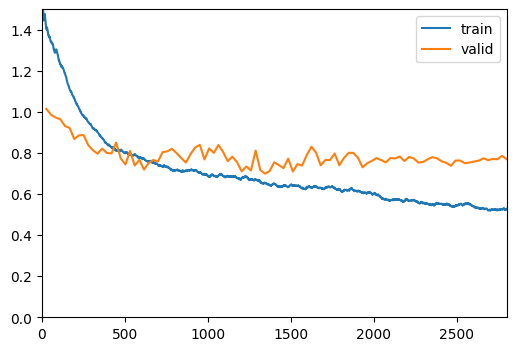

Better model found at epoch 1 with valid_loss value: 0.9853590726852417.
Better model found at epoch 2 with valid_loss value: 0.9719704389572144.
Better model found at epoch 3 with valid_loss value: 0.9634655117988586.
Better model found at epoch 4 with valid_loss value: 0.9306649565696716.
Better model found at epoch 5 with valid_loss value: 0.9210929870605469.
Better model found at epoch 6 with valid_loss value: 0.8670726418495178.
Better model found at epoch 9 with valid_loss value: 0.8379744291305542.
Better model found at epoch 10 with valid_loss value: 0.8129841685295105.
Better model found at epoch 11 with valid_loss value: 0.7963334918022156.
Better model found at epoch 16 with valid_loss value: 0.772796094417572.
Better model found at epoch 17 with valid_loss value: 0.7436671853065491.
Better model found at epoch 19 with valid_loss value: 0.7382643222808838.
Better model found at epoch 21 with valid_loss value: 0.7185272574424744.
Better model found at epoch 42 with valid_loss

In [ ]:
model = TabNetModel(emb_szs, len(to.cont_names), dls.c, n_d=8, n_a=8, n_steps=5, mask_type='entmax');
learn2 = Learner(dls, model, CrossEntropyLossFlat(), opt_func=Adam, lr=3e-3, metrics=[accuracy])
learn2.add_cb(ShowGraphCallback())
learn2.fit_one_cycle(n_epoch = 100,lr_max = 2e-2,  cbs=SaveModelCallback(monitor='valid_loss',comp=None, min_delta=0.0,fname='model2', every_epoch=False, at_end=False, with_opt=False, reset_on_fit=True))

We achieve a better validation loss! However, as the TabNet model has many optional parameters, perhaps we can improve it even more. Let's do a bayesian optimization search for the best parameter configuration!

## Best TabNet model


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:59: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


              precision    recall  f1-score   support

    Atypical       0.55      0.63      0.59       162
      Benign       0.68      0.71      0.69       235
   Malignant       0.72      0.57      0.64       161

    accuracy                           0.65       558
   macro avg       0.65      0.64      0.64       558
weighted avg       0.65      0.65      0.65       558



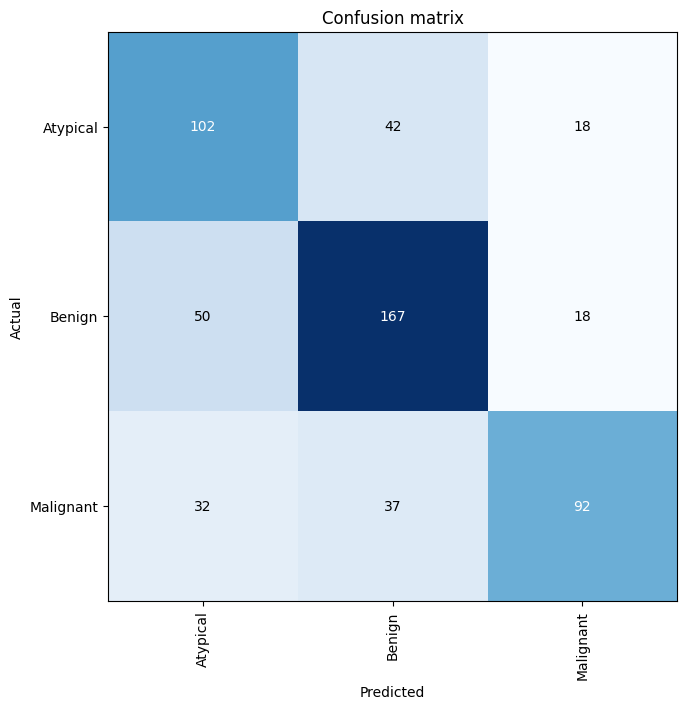

In [ ]:
#The best model that worked:
model = TabNetModel(emb_szs, len(to.cont_names), dls.c, n_d=8, n_a=8, n_steps=5, mask_type='entmax');

learn_final = Learner(dls, model, CrossEntropyLossFlat(), opt_func=Adam, metrics=[accuracy])
learn_final.load('model2')
dls_test = learn_final.dls.test_dl(df_test)
interp = ClassificationInterpretation.from_learner(learn_final, dl=dls_test)
interp.plot_confusion_matrix(figsize=(7, 7), dpi=100)
interp.print_classification_report()

The model is performing better than random selection to the predominant class (42%)

This type of model has another advantage, though, as it provides interpretability:

### TabNet interpretability


**Global interpretability** is the contribution of each of the features to the overall trained model.

**Local interpretability** is how much each of the features contributed for the classification of each of the instances, here visualized for the test data:

In [ ]:
dl = learn_final.dls.test_dl(df_test.iloc[:558], bs=558)
res_explain, res_masks = tabnet_explain(learn_final.model, dl)
feature_importances = tabnet_feature_importances(learn_final.model, dl)


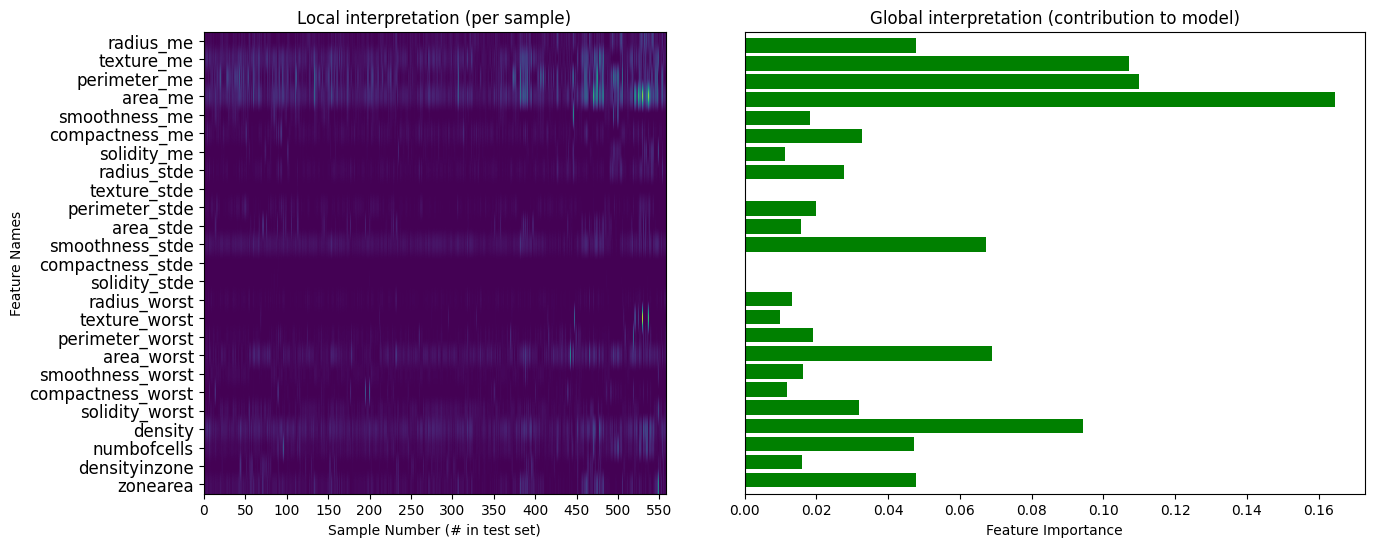

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data and functions
def plot_explain(masks, lbls, ax=None, figsize=(12, 12)):
    "Plots masks with `lbls` (`dls.x_names`)"
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.set_xticks(np.arange(0, len(masks), 50))
    ax.set_yticks(np.arange(0, len(masks[0]), 1.0))
    ax.set_yticklabels(lbls, size=12)
    ax.set_xlabel('Sample Number (# in test set)')
    ax.set_ylabel('Feature Names')
    aspect_ratio = masks.T.shape[1] / masks.T.shape[0]
    ax.imshow(masks.T, aspect=aspect_ratio)

def plot_feature_importances(feature_importances, x_names, ax=None, figsize=(8, 12)):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.barh(x_names, feature_importances, color='g')

    ax.set_xlabel('Feature Importance')
    ax.set_yticks([])  # Remove y-ticks
    ax.set_ylim(-0.75,24.75)  # Adjust x-axis limits to remove padding
    ax.invert_yaxis()


fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].set_title('Local interpretation (per sample)')
plot_explain(res_explain, dl.x_names, ax=axs[0])

axs[1].set_title('Global interpretation (contribution to model)')
plot_feature_importances(feature_importances, dls_test.x_names, ax=axs[1])

plt.subplots_adjust(wspace=0)
plt.show()



In [ ]:
res_explain[543,:]

array([0.30520988, 1.47755623, 0.79966974, 1.59353483, 0.        ,
       0.20328552, 0.04771381, 0.1696291 , 0.        , 0.03988288,
       0.        , 0.66374981, 0.        , 0.        , 0.0508658 ,
       0.        , 0.        , 1.08733404, 0.01479691, 0.        ,
       0.48998892, 1.26021099, 0.53021008, 0.09005925, 0.52973986])

(-0.75, 24.75)

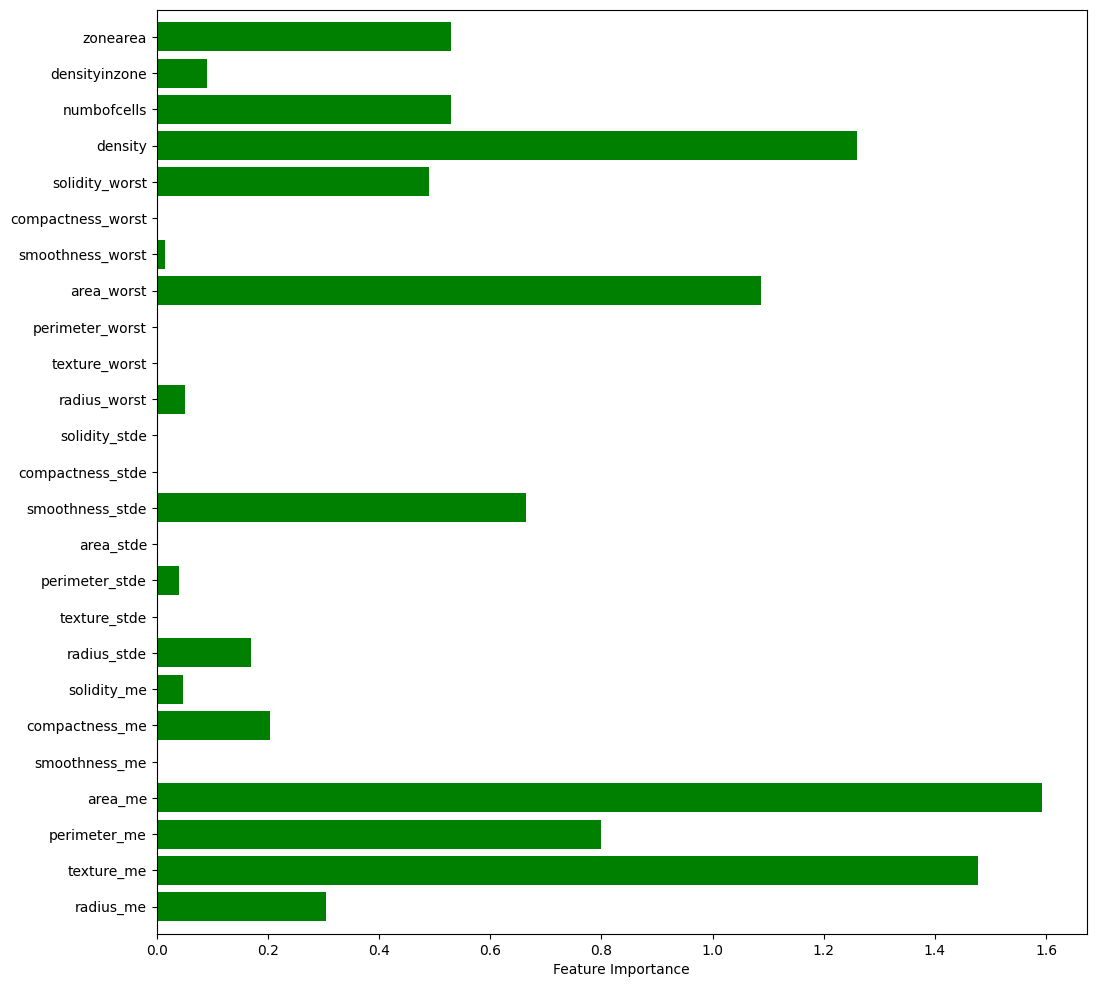

In [ ]:
fig= plt.figure(figsize=(12, 12))

plt.barh(dl.x_names,res_explain[543,:], color='g')
plt.xlabel('Feature Importance')
# plt.yticks([])  # Remove y-ticks
plt.ylim(-0.75,24.75)  # Adjust x-axis limits to remove padding
